## Discretizing the State and Choice Space
Questions about the state space:

- What is an appropriate or optimal discretization of $\mathcal{K}?$

- How we can choose the upper and lower bounds?  

- How many points should there be and how should they be allocated?

Upper and lower bounds $[\underline{k}, \overline{k}]$ for $\mathcal{K}$:

- No golden rule. Mostly trial and error method

- Some models have an explicit lower bound $\underline{k}$ (exogenous or endogenous)

- Almost all models do not have an explicit upper bound $\overline{k}$. In this case, we need to set a sufficiently large upper bound and experiment on it later

How to space the grid points?

- Linearly spaced. Most common and often a good starting point

- Concentrated, usually around $\underline{k}$

How many should there be?

- No rule of thumb here. Need to experiment!

### 1. Discretizing Capital Space
Two methods:

- Uniformly spaced grid

- Double-exponential transformation of a uniformly spaced grid

Uniform points $u_i$ on $[0,\bar{u}]$, construct $k_i$ as
\begin{equation*}
    k_i = \underline{k} + e^{e^{u_i}-1}-1 
\end{equation*}

This gives us a min of $\underline{k}$, max of $\underline{k} + e^{e^{\bar{u}}-1}-1$. Equating this max with $\overline{k}$ gives
\begin{equation*}
    \bar{u} = \log(1+\log(1+ \overline{k} - \underline{k}))
\end{equation*}

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size' : 20, 'lines.linewidth' : 3.5, 'figure.figsize' : (13,7)})

In [2]:
def discretize_capital_uniform(kmin, kmax, n_k):
    return np.linspace(kmin, kmax, n_k)

In [3]:
def discretize_capital_exponential(kmin, kmax, n_k):
    # Find maximum ubar 
    ubar = np.log(1 + np.log(1 + kmax - kmin))
    
    # Make uniform grid
    u_grid = np.linspace(0, ubar, n_k)
    
    # Double-exponentiate uniform grid 
    return kmin + np.exp(np.exp(u_grid) - 1) - 1

Let's see the difference between the two methods with 20 points between 0 and 1,000.

In [4]:
k_grid1 = discretize_capital_uniform(0, 1_000, 20)
k_grid2 = discretize_capital_exponential(0, 1_000, 20)

with np.printoptions(precision=2):
    print(k_grid1)
    print(k_grid2)

[   0.     52.63  105.26  157.89  210.53  263.16  315.79  368.42  421.05
  473.68  526.32  578.95  631.58  684.21  736.84  789.47  842.11  894.74
  947.37 1000.  ]
[0.00e+00 1.22e-01 2.75e-01 4.71e-01 7.26e-01 1.06e+00 1.51e+00 2.13e+00
 3.01e+00 4.28e+00 6.17e+00 9.08e+00 1.38e+01 2.16e+01 3.52e+01 6.04e+01
 1.10e+02 2.12e+02 4.42e+02 1.00e+03]


- Note vastly greater concentration near $\underline{k}$ in the second case: first 5 points are less than 1, next 7 points are less than 10

- Many variations of the non-uniform grid (e.g. could add scalar parameters to double exponential, or try triple exponential)

### 2. Discretizing the Stochastic Process
- Let's assume $\log Z_t = z_t$ follows an AR(1) process with some persistence $\rho_z$ and normal innovations $\varepsilon_t$
$$ z_t = \rho z_{t-1} + \varepsilon_t $$

- It is useful to discretize this continuous process through a finite-state Markov chain that mimics closely the underlying process

- To discretize this continuous process we need

    1. The points on the finite state space (grid points)
    
    2. The transition probabilities

### 2.1. Tauchen's method
Popular method, but worse when $\rho_z$ is close to 1. Let $\tilde{z}$ be the discrete-valued process that approximates $z$ and let $\{z_1,z_2,\ldots,z_N\}$ be the finite set of possible realizations of $\tilde{z}$.

**Choice of points.** Select a maximum value $z_N$ as a multiple $m$ of the unconditional standard deviation, i.e.
$$ z_N = m \left( \frac{\sigma^2_\varepsilon}{1-\rho_z^2} \right)^{0.5} = m \sigma_z, $$ 
let $z_1 = -z_N$ (symmetric distribution) and $\{z_2,\ldots,z_{N-1}\}$ be located in a equispaced manner over the interval $[z_1,z_N]$. Denote with $d$ the distance between successive points in the state space.

**Transition probabilities.** Let
\begin{align*}
    \pi_{jk} &= Pr \{ \tilde{z}_t = z_k | \tilde{z}_{t-1} = z_j \} = Pr \{ z_k - d/2 < \rho_z z_j + \varepsilon_t \leq z_k + d/2 \} \\
        &= Pr \{ z_k - d/2 - \rho_z z_j < \varepsilon_t \leq z_k + d/2 - \rho_z z_j \}
\end{align*}
be the generic transition probability.

Let's consider $F(.)$ to be the standard normal distribution. Then, if $1 < k < N$, for each $j$ choose
$$ \pi_{jk} = F \left( \frac{z_k + d/2 - \rho_z z_j}{\sigma_\varepsilon} \right) - F \left( \frac{z_k - d/2 - \rho_z z_j}{\sigma_\varepsilon} \right)$$
while for the boundaries of the interval $k=1$ and $k=N$ choose
$$ \pi_{j1} = F \left( \frac{z_1 + d/2 - \rho_z z_j}{\sigma_\varepsilon} \right), \quad\text{and}\quad \pi_{jN} = 1 - F \left( \frac{z_N - d/2 - \rho_z z_j}{\sigma_\varepsilon} \right). $$

Clearly, as $d\to 0$ (and therefore $N\to\infty$), the approximation becomes better and better until it converges to the true continous process $z_t$.

**Find Stationary Distribution of Markov Chain.** Given transition matrix $\Pi$, simple and robust way to find stationary distribution is to repeatedly apply transition matrix, updating distribution $\pi$ to $\Pi'\pi$, until convergence up to some tolerance.

In [5]:
def tauchen_Pi(z, rho, sigma):
    # Create the transition matrix, the distance between points, and error standard deviation
    N = len(z)
    Pi = np.empty([N, N])
    d = (z[-1] - z[0]) / (N-1)
    sigma_e = np.sqrt((1 - rho ** 2) * (sigma ** 2))

    # Build Pi
    for j in range(N):
        for k in range(N):
            if k == 0:
                Pi[j,k] = norm.cdf( (z[k] + d/2 - rho * z[j]) / sigma_e )
            elif k == N-1:
                Pi[j,k] = 1 - norm.cdf( (z[k] - d/2 - rho * z[j]) / sigma_e )
            else:
                Pi[j,k] = norm.cdf( (z[k] + d/2 - rho * z[j]) / sigma_e ) - norm.cdf( (z[k] - d/2 - rho * z[j]) / sigma_e )
    
    return Pi

In [6]:
def stationary_markov(Pi, tol=1E-14):
    # Start with uniform distribution over all states
    N = Pi.shape[0]
    pi = np.full(N, 1/N)
    
    # Update distribution using Pi until successive iterations differ by less than tol
    for _ in range(10_000):
        pi_new = Pi.T @ pi
        if np.max(np.abs(pi_new - pi)) < tol:
            return pi_new
        pi = pi_new

In [7]:
def markov_tauchen(rho_z, sigma_z, n_z, m):
    # Calculate the boundaries
    zN = m * sigma_z
    z1 = -zN

    # The z grid points
    z = np.linspace(z1, zN, n_z)

    # Obtain Markov transition matrix Pi and its stationary distribution
    Pi = tauchen_Pi(z, rho_z, sigma_z)
    pi = stationary_markov(Pi)

    # z is log tfp, get tfp z and scale so that mean is 1
    z = np.exp(z)
    z /= np.vdot(pi, z)

    return z, pi, Pi

### Example
Let's try $\rho_z=0.975$, $\sigma_z=0.7$, $n_z=7$, and $m=3$.

In [8]:
z, piz, Piz = markov_tauchen(0.975, 0.7, 7, 3)

Verify mean of $y$ is 1 as desired:

In [9]:
np.vdot(piz, z)

1.0

### 2.2. Rouwenhorst method
Let's consdier $n-1$ independent hidden binary states (can be 0 or 1), each of which have probability $p$ of staying at current value, $1-p$ of switching. We have $n$ possible values of this sum, from 0 to $n-1$; as $n$ gets higher, the sum behaves more and more like AR(1) with normal innovations.

**Step 1.** For $n=2$
$$
\Pi_{2}=\begin{bmatrix}p & 1-p\\
1-p & p
\end{bmatrix} 
$$

**Step 2.** For $n\geq 3$ define recursively $\Pi_n$ as the $n\times n$ matrix
$$
\Pi_{n}=p\begin{bmatrix}\Pi_{n-1} & \mathbf{0}\\
\mathbf{0}' & 0
\end{bmatrix}+(1-p)\begin{bmatrix}\mathbf{0} & \Pi_{n-1}\\
0 & \mathbf{0}'
\end{bmatrix}+(1-p)\begin{bmatrix}\mathbf{0}' & 0\\
\Pi_{n-1} & \mathbf{0}
\end{bmatrix}+p\begin{bmatrix}0 & \mathbf{0}'\\
\mathbf{0} & \Pi_{n-1}
\end{bmatrix} 
$$

**Step 3.** Divide all but the top and botton rows by 2 so that their elements add up to one.

One can show that this Markov chain converges to an invariant binomial distribution. Computing analytially the first two moments for an AR(1) process:
- The "persistence" $\rho_z$ from regressing $z_t$ on $z_{t-1}$ is $2p-1$, so to match desired persistence $\rho_z$ set
$$
p = \frac{1+\rho}{2}
$$

- $z_t$ is sum of $n-1$ independent states with 50-50 probability of being 0 or 1, so its stationary distribution is the binomial distribution with $n-1$ trials and success probability 1/2, which has standard deviation $\sigma_z = \sqrt{n-1}/2$.

- So to match desired cross-sectional standard deviation of $z_t$, scale it by the constant
$$
\alpha \equiv \frac{2 \sigma_z}{\sqrt{n-1}}
$$

In [10]:
def rouwenhorst_Pi(N, p):
    # Step 1
    Pi = np.array([[p, 1 - p],
                   [1 - p, p]])
    
    # Step 2
    for n in range(3, N + 1):
        Pi_old = Pi
        Pi = np.zeros((n, n))
        
        Pi[:-1, :-1] += p * Pi_old
        Pi[:-1, 1:] += (1 - p) * Pi_old
        Pi[1:, :-1] += (1 - p) * Pi_old
        Pi[1:, 1:] += p * Pi_old
        Pi[1:-1, :] /= 2
        
    return Pi

In [11]:
def markov_rouwenhorst(rho_z, sigma_z, n_z):
    # Choose inner-switching probability p to match persistence rho_z
    p = (1+rho_z)/2
    
    # Start with states from 0 to n_z-1, scale by alpha to match standard deviation sigma_z
    s = np.arange(n_z)
    alpha = 2*sigma_z/np.sqrt(n_z-1)
    s = alpha*s
    
    # Obtain Markov transition matrix Pi and its stationary distribution
    Pi = rouwenhorst_Pi(n_z, p)
    pi = stationary_markov(Pi)
    
    # z is log tfp, get tfp z and scale so that mean is 1
    y = np.exp(s)
    y /= np.vdot(pi, y)
    
    return y, pi, Pi

### Example
Let's try $\rho_z=0.975$, $\sigma_z=0.7$, $n_z=7$.

In [12]:
z, piz, Piz = markov_rouwenhorst(0.975, 0.7, 7)

Verify mean of $y$ is 1 as desired:

In [13]:
np.vdot(piz, z)

1.0

Verify standard deviation is $\sigma=0.7$:

In [14]:
mean_log_z = np.vdot(piz, np.log(z))
sd_log_z = np.sqrt(np.vdot(piz, (np.log(z) - mean_log_z)**2))
sd_log_z

0.700000000000348

## Brute Force Search VFI
Consider the *stochastic neoclassical growth model* with inelastic labor supply. The economy is populated with infinitely many all-identical households who value consumption and they maximize the expected utility from consumption 
\begin{gather*}
    V(z,k) = \max_{c,k'} \left\{ \frac{c^{1-\sigma^{-1}}}{1-\sigma^{-1}} + \beta \mathbb{E} [V(z',k')|z] \right\} \\
    \text{s.t.} \quad c + k' = z k^{\alpha} + (1-\delta) k
\end{gather*}
and $z$, the technology shock, follows an AR(1) process.

Let's consider the case where $\sigma = 1$ and $\delta = 1$. Thus, the utility is logarithmic and there is full capital depreciation every period. One can easily verify that the solution for this problem is
$$
k' = \alpha\beta z k^{\alpha}, \qquad\text{and}\qquad c = (1-\alpha\beta) z k^{\alpha} \tag{1}
$$

So we have an *analytical solution* to the neoclassical problem that we can use to check the accuracy of the value function iteration method proposed by the CMT.

Let's start by assuming some values for the parameters in this model

In [15]:
# Baseline parameters
sigma   = 1
delta   = 1
beta    = 0.97
alpha   = 0.33

# Technology process
rho_z   = 0.95
sigma_z = 0.03
n_z     = 7

# Capital grid
kmin    = 0.01
kmax    = 5
n_k     = 50

We are going to use the double exponential and Rouwenhorst's method...

In [16]:
k_grid = discretize_capital_exponential(kmin, kmax, n_k)
z_grid, piz, Piz = markov_rouwenhorst(rho_z, sigma_z, n_z)

### 1. Value Function Iteration

**Step 1. Discounting and expectations** 

Define "end-of-period" value function $W_t$ as

$$
W_t(z,k') \equiv \beta \mathbb{E}[V_{t+1}(z',k')|k] \tag{2}
$$

Take expectations in (2) by multiplying by Markov matrix $\Pi_z$, so if $V_{t+1}(z,k)$ is in $n_z\times n_k$ array `V1`, get $n_z\times n_k$ array `W` of $W_{t}$.

**Step 2. Initialize the value function and consumption**

Our focus is to solve for the $V_{t}(z,k)$, an $n_z\times n_k$ array `V`. Intilialize `V` to a low negative value. 

Then, for every value on the grids, compute the *potential* consumption value. 

- If $c>0$ compute the value function using the utility function $u(c)$ and the continuation value $W_t$.

- If $c\leq 0$, give the agent a high negative value so he/she will never choose this point.  

**Step 3. Check against the current best**

Only if the value function computed before is greater than the initial `V`, compute the optimal values for capital `gk` and consumption `gc`.

In [17]:
def value_function(V1, Piz, k_grid, z_grid, beta, sigma, delta, alpha):
    # Step 1
    W = (beta * Piz) @ V1
    
    V = np.empty_like(V1)
    gk = np.empty_like(V1)
    gc = np.empty_like(V1)
    for z in range(len(z_grid)):
        for k in range(len(k_grid)):
            # Step 2
            V[z,k]    = -1E50 
            for kp in range(len(k_grid)):
                cval = z_grid[z] * k_grid[k] ** alpha + (1-delta) * k_grid[k] - k_grid[kp]

                if cval > 0.0:
                    if sigma == 1:
                        uval = np.log(cval)
                    else:
                        uval = cval ** (1-1/sigma) / (1-1/sigma)
                else:
                    uval = -1E50
                
                vval = uval + W[z,kp]

                # Step 3
                if vval > V[z,k]:
                    V[z,k]  = vval
                    gk[z,k] = k_grid[kp]
                    gc[z,k] = cval

    return V, gk, gc

This function takes in an $n_z\times n_k$ array `V` containing tomorrow's value function $V_{t+1}$ at every point on the grid. It also takes in the $n_z\times n_k$ Markov matrix `Piz` ($\Pi_z$), the length-$n_k$ asset grid `k_grid`, the length-$n_z$ array `z_grid` of technology $z_t$, and the scalars `beta` ($\beta$), `sigma` ($\sigma$), `delta` ($\delta$), and `alpha` ($\alpha$).

It outputs $n_z\times n_k$ arrays containing today's value function $V_{t}$ and the policies $k'$ and $c$ at every point on the grid.

### 2. Obtaining steady-state policies
To obtain steady-state $V$ and policies $k'$ and $c$, we need:

- Initial guess for steady-state $V$

- Iterate backward using `value_function` until convergence criterion hit

We can try try:

- $V$ equals 1% of aggregate income

- terminate backward iteration once the max distance between the value function on two successive iterations falls below some tolerance, say $10^{-9}$

    - (also max number of iterations, say 10,000, as a fail-safe so that the computer doesn't run forever if it isn't converging)

In [18]:
def policy_ss(Piz, k_grid, z_grid, beta, sigma, delta, alpha, tol=1E-9):
    # Initial guess for V
    income = z_grid[:, np.newaxis] * k_grid[np.newaxis, :] ** alpha + (1-delta) * k_grid[np.newaxis, :]
    V = 0.01*income
    
    # Iterate until maximum distance between two iterations falls below tol (fail-safe max of 10,000 iterations)
    for it in range(10_000):
        V, gk, gc = value_function(V, Piz, k_grid, z_grid, beta, sigma, delta, alpha)
        
        # After iteration 0, can compare new policy function to old one
        if it > 0 and np.max(np.abs(V - V_old)) < tol:
            return V, gk, gc
        
        V_old = V

In [19]:
V, gk, gc = policy_ss(Piz, k_grid, z_grid, beta, sigma, delta, alpha)

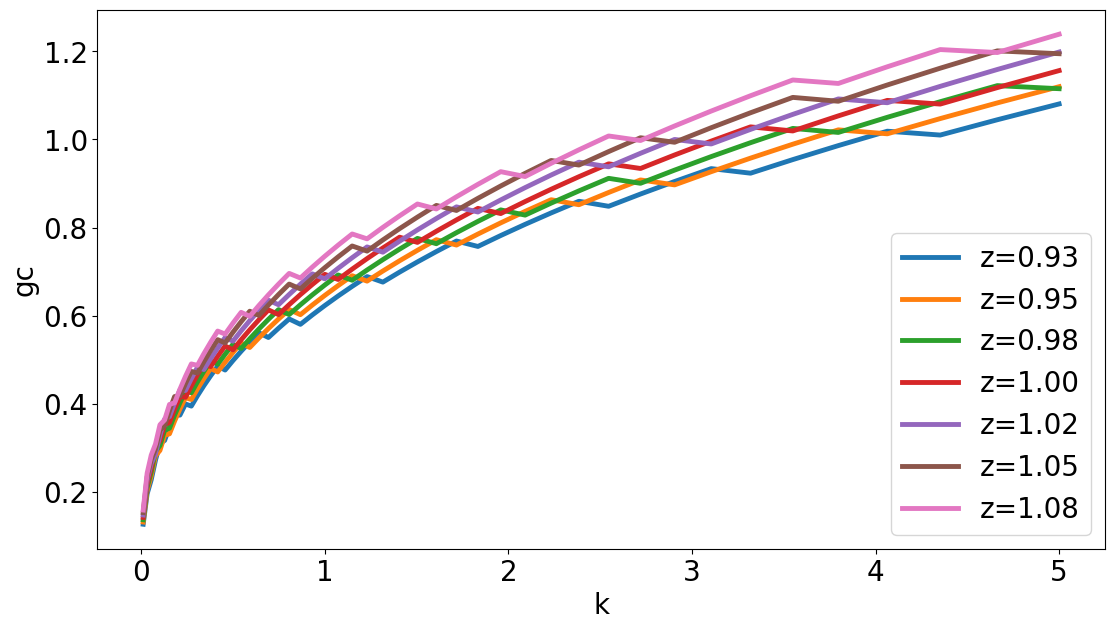

In [20]:
for s, zs in enumerate(z_grid):
    plt.plot(k_grid, gc[s, :], label=f'z={zs:.2f}')
plt.legend()
plt.xlabel('k')
plt.ylabel('gc');

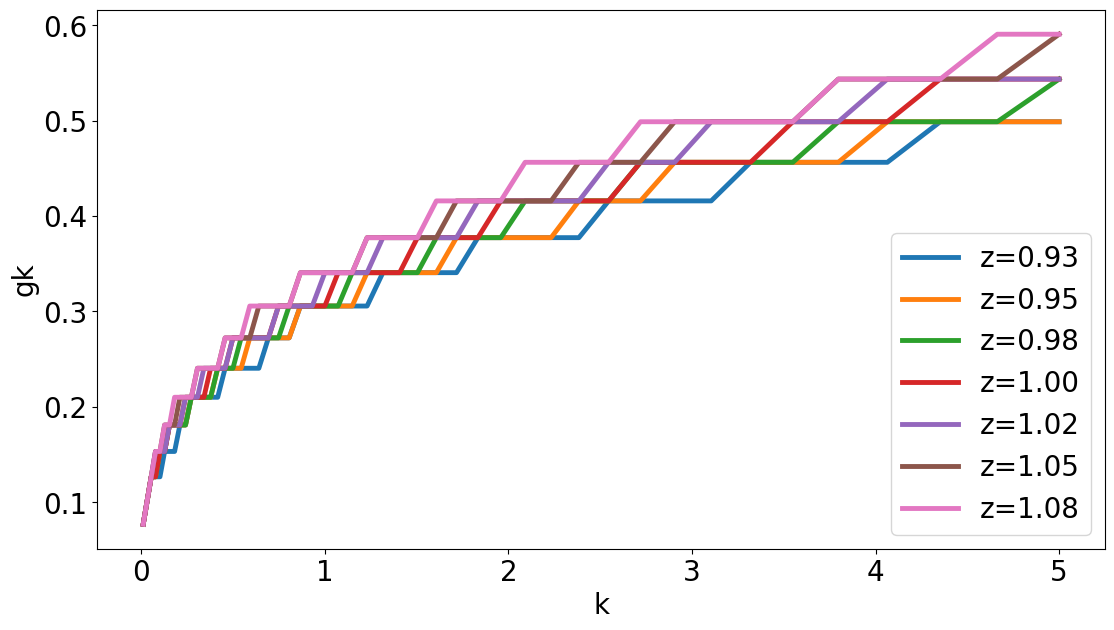

In [21]:
for s, zs in enumerate(z_grid):
    plt.plot(k_grid, gk[s, :], label=f'z={zs:.2f}')
plt.legend()
plt.xlabel('k')
plt.ylabel('gk');

To verify the accuracy of our solution, let's compare it with the analytical solution in (1):

In [22]:
gk_true = alpha * beta * z_grid[:, np.newaxis] * (k_grid[np.newaxis, :] ** alpha)
gc_true = (1 - alpha * beta) * z_grid[:, np.newaxis] * (k_grid[np.newaxis, :] ** alpha)

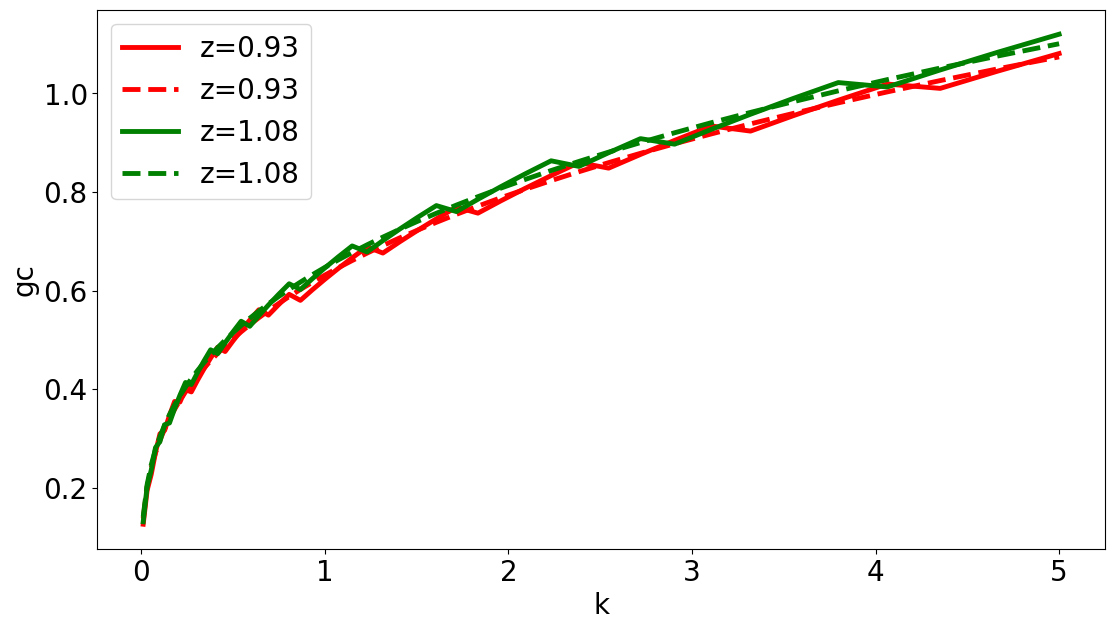

In [23]:
# Consumption policy function 
colors = ['r','g']
for s, zs in enumerate(z_grid[0:7:6]):
    plt.plot(k_grid, gc[s, :], label=f'z={zs:.2f}', color = colors[s])
    plt.plot(k_grid, gc_true[s, :], label=f'z={zs:.2f}', linestyle='dashed', color = colors[s])
plt.legend()
plt.xlabel('k')
plt.ylabel('gc');

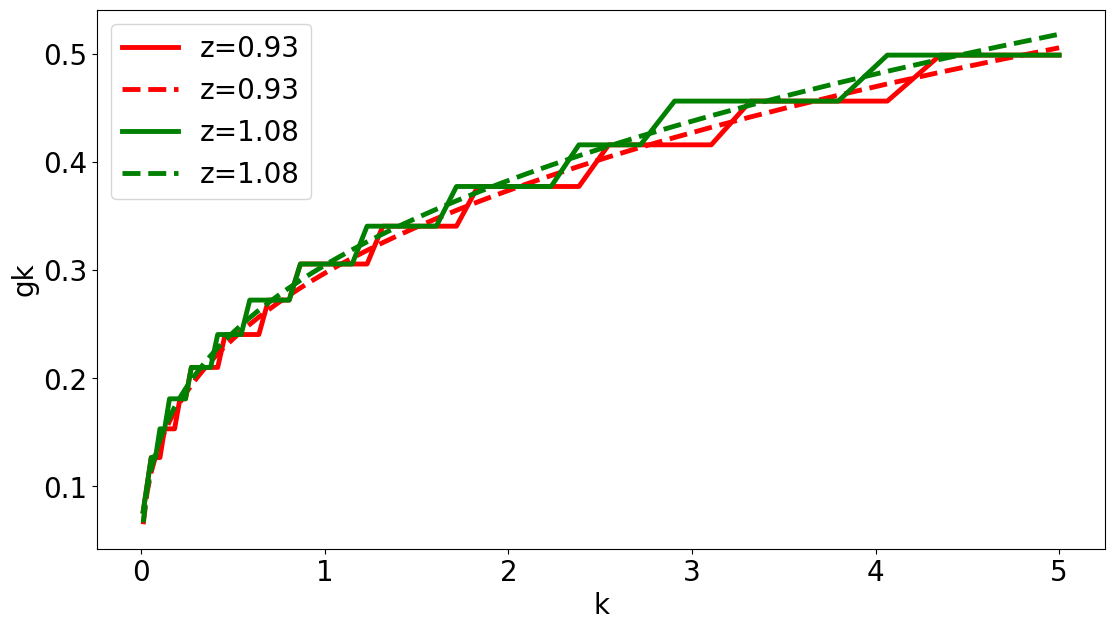

In [24]:
# Capital policy function
for s, zs in enumerate(z_grid[0:7:6]):
    plt.plot(k_grid, gk[s, :], label=f'z={zs:.2f}', color = colors[s])
    plt.plot(k_grid, gk_true[s, :], label=f'z={zs:.2f}', linestyle='dashed', color = colors[s])
plt.legend()
plt.xlabel('k')
plt.ylabel('gk');

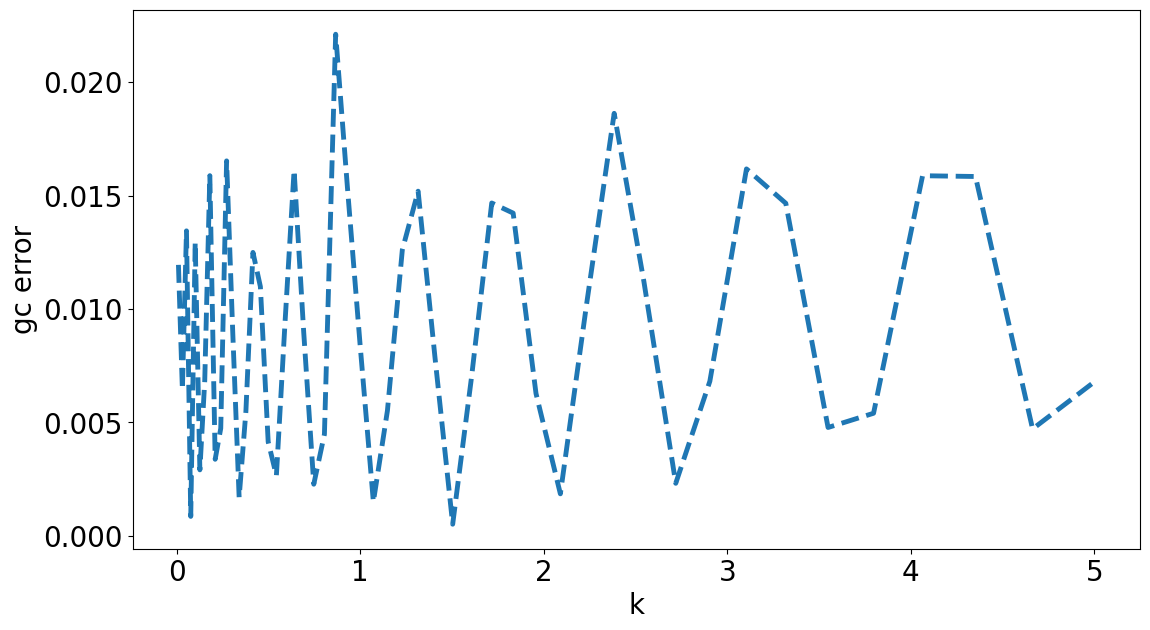

In [25]:
# Consumption policy function error
gc_error = np.abs(gc_true-gc)

for s, zs in enumerate(z_grid[0:1]):
    plt.plot(k_grid, gc_error[s, :], label=f'z={zs:.2f}', linestyle='dashed')
plt.xlabel('k')
plt.ylabel('gc error');

### Advantages:
- Always works. It can handle discontinuities, non-convex budget constraints, non-concave objective functions
- Some problemas are naturally a discrete choice, e.g., work or study
- Easy for compilers to optimize and easy to parallelized
- Full discretization is a good starting point to calculate the computational solution to the *stochastic neoclassical growth model*
- We can use the BFS method to solve more complicated problems, e.g., when $\sigma\neq 1$ and $\delta\neq 1$ 

### Disadvantages:
- Very slow relatively to other algorithms, e.g., it takes around 20 seconds to be computed in this example
- Suffers from the *curse of dimensionality*
- The optimal solution for capital `gk` only considers the grid points defined on the `k_grid`

### 3. Additional details

We can improve the speed of the BFS method by *exploiting monotonicity* and *exploiting concavity*

**Monotonicity.** Very often, one has policy functions that are monotone
$$
k' (k_2, z) \geq k'(k_1, z) \qquad \text{for all } k_2\geq k_1 \text{ and } z
$$

We can use this idea in the code by:
1. Computing $k'(k_1, z)$ by checking all $k_1,\ldots,k_n$. Set $i=1$ and
2. compute $k'(k_{i+1},z)$ by checking all $k'(k_i,z),\ldots,k_n$. If $i+1=n$, stop.

In [26]:
def value_function_mono(V1, Piz, k_grid, z_grid, beta, sigma, delta, alpha):
    # Step 1
    W = (beta * Piz) @ V1
    
    V = np.empty_like(V1)
    gk = np.empty_like(V1)
    gc = np.empty_like(V1)
    gki = np.empty_like(V1, dtype=np.int32)
    for z in range(len(z_grid)):
        for k in range(len(k_grid)):
            # Step 2
            V[z,k]    = -1E50

            # Monotonicity
            if k==0:
                k_lb = 0
            else:
                k_lb = gki[z,k-1]

            for kp in range(k_lb,len(k_grid)):
                cval = z_grid[z] * k_grid[k] ** alpha + (1-delta) * k_grid[k] - k_grid[kp]

                if cval > 0.0:
                    if sigma == 1:
                        uval = np.log(cval)
                    else:
                        uval = cval ** (1-sigma) / (1-sigma)
                else:
                    uval = -1E50
                
                vval = uval + W[z,kp]

                # Step 3
                if vval > V[z,k]:
                    V[z,k]  = vval
                    gk[z,k] = k_grid[kp]
                    gc[z,k] = cval
                    gki[z,k] = kp

    return V, gk, gc

In [27]:
def policy_ss_mono(Piz, k_grid, z_grid, beta, sigma, delta, alpha, tol=1E-9):
    # Initial guess for V
    income = z_grid[:, np.newaxis] * k_grid[np.newaxis, :] ** alpha
    V = 0.01*income
    
    # Iterate until maximum distance between two iterations falls below tol (fail-safe max of 10,000 iterations)
    for it in range(10_000):
        V, gk, gc = value_function_mono(V, Piz, k_grid, z_grid, beta, sigma, delta, alpha)
        
        # After iteration 0, can compare new policy function to old one
        if it > 0 and np.max(np.abs(V - V_old)) < tol:
            return V, gk, gc
        
        V_old = V

In [28]:
V_mono, gk_mono, gc_mono = policy_ss_mono(Piz, k_grid, z_grid, beta, sigma, delta, alpha)

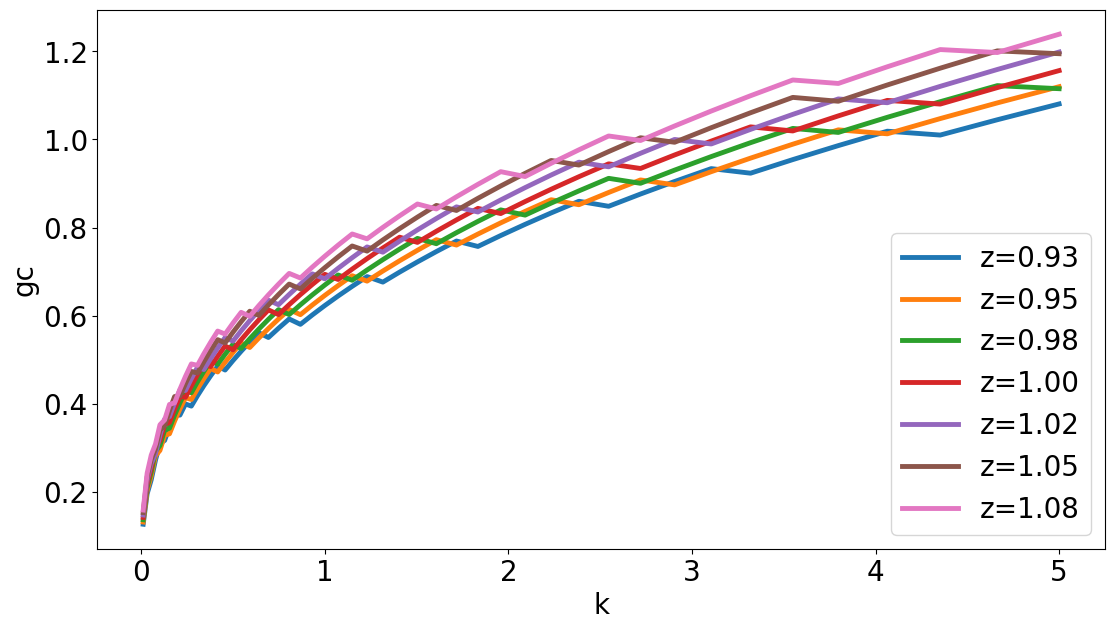

In [29]:
for s, zs in enumerate(z_grid):
    plt.plot(k_grid, gc_mono[s, :], label=f'z={zs:.2f}')
plt.legend()
plt.xlabel('k')
plt.ylabel('gc');

**Advantages**
- Improves on brute-force
- Applies to many models
- Can still parallelize easily

**Disadvantages**
- None

**Concavity.** In many applications, the objective function is a concave function
$$
H(k') := u(c(z,k,k')) + \beta \mathbb{E} V(z',k') 
$$
where $H(.)$ is a concave function in $k'$ for all $z,k$. 

We can use this idea in the code by:
1. Computing $H(k'=k_1)$. Set $i=1$ and
2. if $i=n$ or $H(k_{i+1}) < H(k_i)$, then stop. The optimum is $k'=k_i$. Otherwise increment $i$ and set it to 2

In [30]:
def value_function_mono_conc(V1, Piz, k_grid, z_grid, beta, sigma, delta, alpha):
    # Step 1
    W = (beta * Piz) @ V1
    
    V = np.empty_like(V1)
    gk = np.empty_like(V1)
    gc = np.empty_like(V1)
    gki = np.empty_like(V1, dtype=np.int32)
    for z in range(len(z_grid)):
        for k in range(len(k_grid)):
            # Step 2
            V[z,k]    = -1E50

            # Monotonicity
            if k==0:
                k_lb = 0
            else:
                k_lb = gki[z,k-1]

            for kp in range(k_lb,len(k_grid)):
                cval = z_grid[z] * k_grid[k] ** alpha + (1-delta) * k_grid[k] - k_grid[kp]

                if cval > 0.0:
                    if sigma == 1:
                        uval = np.log(cval)
                    else:
                        uval = cval ** (1-sigma) / (1-sigma)
                else:
                    uval = -1E50
                
                vval = uval + W[z,kp]

                # Step 3
                if vval > V[z,k]:
                    V[z,k]  = vval
                    gk[z,k] = k_grid[kp]
                    gc[z,k] = cval
                    gki[z,k] = kp
                else:
                    # Concavity
                    break

    return V, gk, gc

In [31]:
def policy_ss_mono_conc(Piz, k_grid, z_grid, beta, sigma, delta, alpha, tol=1E-9):
    # Initial guess for V
    income = z_grid[:, np.newaxis] * k_grid[np.newaxis, :] ** alpha
    V = 0.01*income
    
    # Iterate until maximum distance between two iterations falls below tol (fail-safe max of 10,000 iterations)
    for it in range(10_000):
        V, gk, gc = value_function_mono_conc(V, Piz, k_grid, z_grid, beta, sigma, delta, alpha)
        
        # After iteration 0, can compare new policy function to old one
        if it > 0 and np.max(np.abs(V - V_old)) < tol:
            return V, gk, gc
        
        V_old = V

In [32]:
V_mono_conc, gk_mono_conc, gc_mono_conc = policy_ss_mono_conc(Piz, k_grid, z_grid, beta, sigma, delta, alpha)

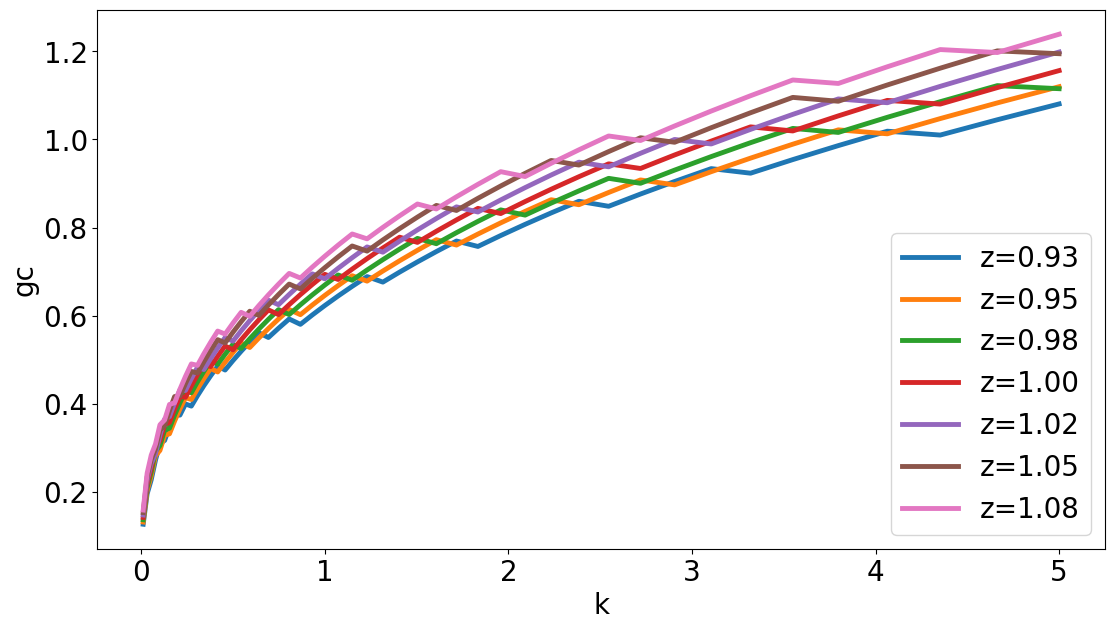

In [33]:
for s, zs in enumerate(z_grid):
    plt.plot(k_grid, gc_mono_conc[s, :], label=f'z={zs:.2f}')
plt.legend()
plt.xlabel('k')
plt.ylabel('gc');

**Advantages**
- It can be paired with monotonicity. Monotonicity provides a lowerbound on the search space
- Very powerful. Essentially, it gives an upperbound on the search space
- Apply not only to concave functions, but also to strictly quasi-concave functions

**Disadvantages**
- Not as generally applicable as monotonicity.
- Like monotonicity, dangerous if not sure it holds. If it doesn't hold, then VFI may not converge or may converge to something wrong. 
- When working with a concave function, can use FOCs instead which may be even faster. However, grid search w/ speedups is as reliable as it gets.
- Policy function iteration, which I will discuss shortly, does not preserve concavity.